**Demonstrate the effect of Interference Mitigation on the Cross-Ambiguity Function**

In [11]:
%matplotlib notebook

# Load the required libraries
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import ipyvolume as ipv
import ipywidgets as widgets
from ipyfilechooser import FileChooser
from IPython.display import display

# Custom library for the generation of the C/A code and for signal acquisition
import cafwidget as caf

**Set the signal characteristics**

In [12]:
signal_char = {
               "fs" : 10e6,          # Sampling frequency
               "fi" : 0e3,         # Intermediate frequency
              }

isComplex = True   # Tell if the samples are in I/Q format
is16Bits  = False  # Tell if the samples are stored on 16 bits/byte
isRtl = False      # Tell if the data were collected using an RTl-SDR dongle

**Acquisition parameters**

In [13]:
acq_char = {
            "Nd" : 121,              # Number of Doppler bins
            "DopStep" : 125,        # Doppler bin size in Hz
            "K" : 1                 # Number of non-coherent integrations
           }

**Open the input file and read the data**

In [14]:
# Create and display a FileChooser widget
fc = FileChooser()
display(fc)

FileChooser(path='/home/daniele/Documents/Projects/2021/Jamming demo', filename='', title='HTML(value='', layo…

In [15]:
filename = fc.selected
if filename is None :
    filename = "./data/JammerData.bin"
    
#open the binary file
fid = open(filename,'rb');

secondOfData = 0.01
N = np.int(np.floor( secondOfData * signal_char["fs"] ))

if isComplex :
    if is16Bits :    
        data = np.fromfile(fid, dtype = np.int16, count = 2 * N )
    else :
        if isRtl :
            data = np.fromfile(fid, dtype = np.uint8, count = 2 * N )
            data = data.astype(dtype = np.int8) - 127
        else :
            data = np.fromfile(fid, dtype = np.int8, count = 2 * N )
    data = data[::2] + 1j*data[1::2]
else:
    if is16Bits :    
        data = np.fromfile(fid, dtype = np.int16, count = N )
    else :
        data = np.fromfile(fid, dtype = np.int8, count = N )

**Create the CAF object**

In [16]:
# SVID of the satellite signal to acquire
sat = 7


CAF = caf.CAFInteractive(sat, data, signal_char, acq_char )

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='$T_h$', max=20.0, min=1.0),…

<IPython.core.display.Javascript object>


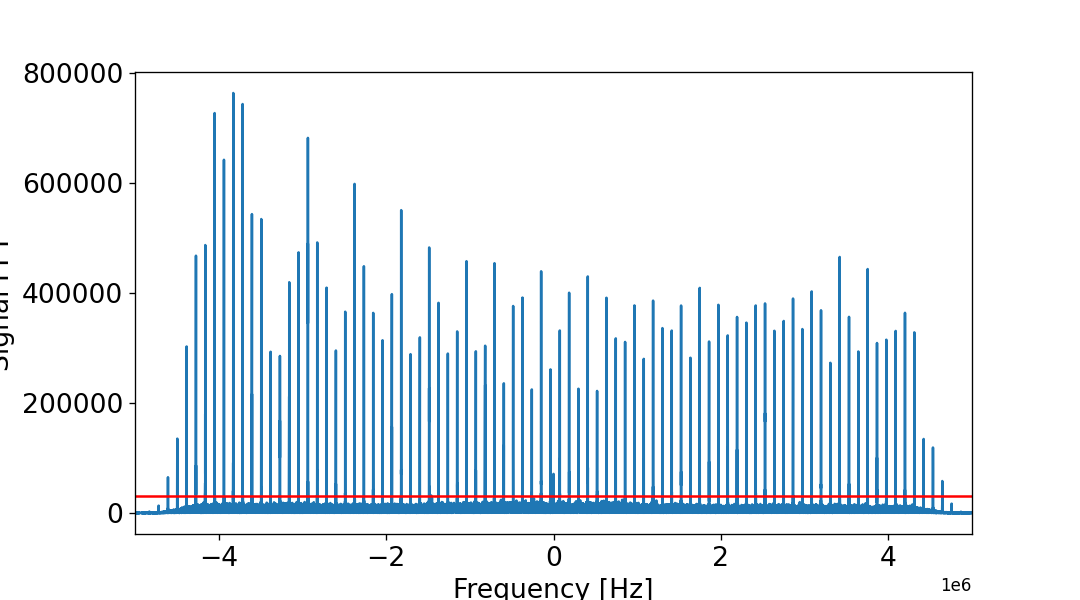

interactive(children=(IntSlider(value=3, description='Th', max=10, min=1), Output()), _dom_classes=('widget-in…

<function __main__.update(Delta)>

In [26]:
fdata = np.fft.fft( CAF.data )
fdata = np.fft.fftshift( fdata )
freq = np.linspace(-signal_char['fs']/2, signal_char['fs']/2, len(fdata) )

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(9, 5)
ax.plot(freq, abs(fdata))
ax.set_xlabel('Frequency [Hz]', fontsize = 16)
ax.set_ylabel('Signal FFT', fontsize = 16)
ax.tick_params(labelsize=16)
ax.set_xlim([-signal_char['fs']/2, signal_char['fs']/2])

# robust estimator for the total standard deviation
sigma = stats.median_abs_deviation( fdata.real, scale='normal' ) * np.sqrt(2)
# sigma = np.std(fdata)

line, = ax.plot([-signal_char['fs']/2, signal_char['fs']/2], [sigma, sigma], 'r')
        
def update( Delta ) :
    line.set_ydata([Delta * sigma, Delta * sigma])
    fig.canvas.draw_idle()
        
        
widgets.interact(update, Delta = widgets.IntSlider(value=3, min=1, max=10, step = 1, description='Th'))
